In [27]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [28]:
using_colab = False

In [29]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib scikit-learn
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

In [30]:
import os
from glob import glob

import numpy as np
import utils

from matplotlib import pyplot as plt

COLORS = utils.pascal_color_map()[1:]

1. Load the data

In [31]:
# Preapre the data path
ANNOT_DIR = "/fsx-onevision/shoubhikdn/release/roboflow/gt-annotations" # PUT YOUR ANNOTATION PATH HERE
IMG_DIR = "/fsx-onevision/shoubhikdn/release/roboflow/metaclip-images" # PUT YOUR IMAGE PATH HERE
# IMG_DIR = "/fsx-onevision/shoubhikdn/release/roboflow/sa1b-images"

# Load the SA-CO/Gold annotation files
annot_file_list = glob(os.path.join(ANNOT_DIR, "*gold*.json"))
annot_dfs = utils.get_annot_dfs(file_list=annot_file_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:07<00:00,  2.99it/s]


Show the annotation files being loaded

In [32]:
annot_dfs.keys()

dict_keys(['gold_crowded_merged_b_release_test', 'gold_metaclip_merged_b_release_test', 'gold_attributes_merged_c_release_test', 'gold_wiki_common_merged_c_release_test', 'gold_crowded_merged_c_release_test', 'gold_fg_food_merged_a_release_test', 'gold_fg_sports_equipment_merged_a_release_test', 'gold_wiki_common_merged_b_release_test', 'gold_attributes_merged_b_release_test', 'gold_metaclip_merged_c_release_test', 'gold_sa1b_merged_a_release_test', 'gold_fg_food_merged_b_release_test', 'gold_sa1b_merged_b_release_test', 'gold_wiki_common_merged_a_release_test', 'gold_fg_sports_equipment_merged_b_release_test', 'gold_attributes_merged_a_release_test', 'gold_fg_food_merged_c_release_test', 'gold_crowded_merged_a_release_test', 'gold_sa1b_merged_c_release_test', 'gold_metaclip_merged_a_release_test', 'gold_fg_sports_equipment_merged_c_release_test'])

2. Examples of the data format

In [33]:
annot_dfs["gold_fg_sports_equipment_merged_a_release_test"].keys()

dict_keys(['info', 'images', 'annotations', 'categories', 'licenses'])

In [34]:
annot_dfs["gold_fg_sports_equipment_merged_a_release_test"]["info"]

{'version': 'v1',
 'date': '2025-10-03',
 'description': 'SA-Co/Gold-Wiki-Sports Equipment-A'}

In [35]:
annot_dfs["gold_fg_sports_equipment_merged_a_release_test"]["images"].head(3)

,id,file_name,text_input,width,height,queried_category,is_instance_exhaustive,is_pixel_exhaustive
0,10000000,1/100001/metaclip_1_100001_45c5172522d13a967d4...,Adidas Tango 12,2560,1744,0,1,1
1,20000000,1/100201/metaclip_1_100201_0533c5066abc0cb464e...,rowing boat,1000,479,1,1,1
2,20000001,1/100201/metaclip_1_100201_0533c5066abc0cb464e...,the horse jumping obstacles,1000,479,4002,1,1


In [36]:
annot_dfs["gold_fg_sports_equipment_merged_a_release_test"]["annotations"].head(3)

,area,id,image_id,frame_index,source,bbox,segmentation,category_id,iscrowd
0,0.006835,1,20000000,-1,manual,"[0.42800000309944153, 0.6931106448173523, 0.19...",{'counts': 'QaX67h>3L2O2N1O1011O1N2OO00001N1O1...,1,0
1,0.208374,2,30000000,-1,manual,"[0.051080550998449326, 0.02916666679084301, 0....",{'counts': 'UZ<2i>7I7J4L5K4M3M4K4M4L3M4L3L4M4L...,1,0
2,0.287152,3,30000000,-1,manual,"[0.3948919475078583, 0.17083333432674408, 0.54...",{'counts': 'i]n28b>7K5N2I6C>J5L5K4L5J5L4N2J7M2...,1,0


3. Visualize the data

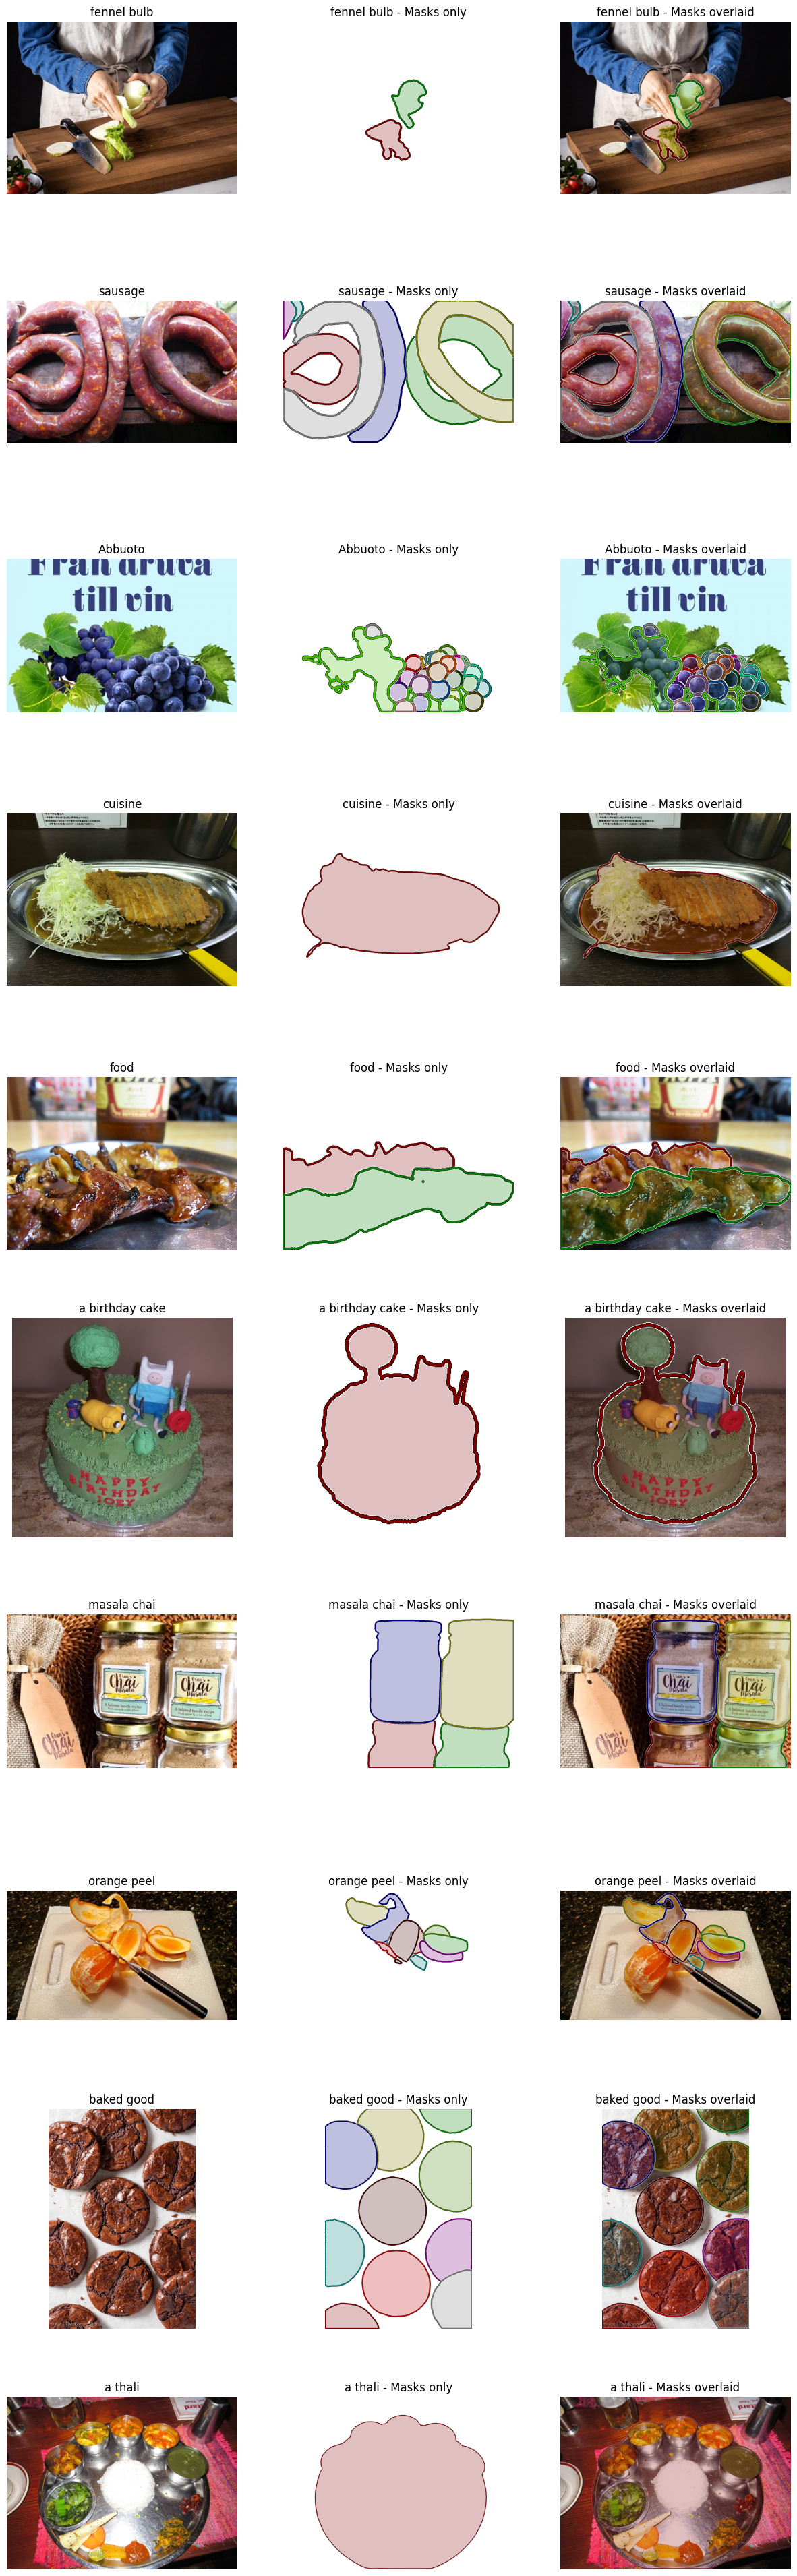

In [38]:
# Select a target dataset
target_dataset_name = "gold_fg_food_merged_a_release_test"

import cv2
from pycocotools import mask as mask_util
from collections import defaultdict

# Group GT annotations by image_id
gt_image_np_pairs = annot_dfs[target_dataset_name]["images"]
gt_annotations = annot_dfs[target_dataset_name]["annotations"]

gt_image_np_map = {img["id"]: img for _, img in gt_image_np_pairs.iterrows()}
gt_image_np_ann_map = defaultdict(list)
for _, ann in gt_annotations.iterrows():
    image_id = ann["image_id"]
    if image_id not in gt_image_np_ann_map:
        gt_image_np_ann_map[image_id] = []
    gt_image_np_ann_map[image_id].append(ann)

positiveNPs = common_image_ids = [img_id for img_id in gt_image_np_map.keys() if img_id in gt_image_np_ann_map and gt_image_np_ann_map[img_id]]
negativeNPs = [img_id for img_id in gt_image_np_map.keys() if img_id not in gt_image_np_ann_map or not gt_image_np_ann_map[img_id]]

num_image_nps_to_show = 10
fig, axes = plt.subplots(num_image_nps_to_show, 3, figsize=(15, 5 * num_image_nps_to_show))
for idx in range(num_image_nps_to_show):
    rand_idx = np.random.randint(len(positiveNPs))
    image_id = positiveNPs[rand_idx]
    noun_phrase = gt_image_np_map[image_id]["text_input"]
    img_rel_path = gt_image_np_map[image_id]["file_name"]
    full_path = os.path.join(IMG_DIR, f"{img_rel_path}")
    img = cv2.imread(full_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gt_annotation = gt_image_np_ann_map[image_id]

    def display_image_in_subplot(img, axes, row, col, title=""):
        axes[row, col].imshow(img)
        axes[row, col].set_title(title)
        axes[row, col].axis('off')


    noun_phrases = [noun_phrase]
    annot_masks = [mask_util.decode(ann["segmentation"]) for ann in gt_annotation]

    # Show the image
    display_image_in_subplot(img, axes, idx, 0, f"{noun_phrase}")

    # Show all masks over a white background
    all_masks = utils.draw_masks_to_frame(
        frame=np.ones_like(img)*255, masks=annot_masks, colors=COLORS[: len(annot_masks)]
    )
    display_image_in_subplot(all_masks, axes, idx, 1, f"{noun_phrase} - Masks only")

    # Show masks overlaid on the image
    masked_frame = utils.draw_masks_to_frame(
        frame=img, masks=annot_masks, colors=COLORS[: len(annot_masks)]
    )
    display_image_in_subplot(masked_frame, axes, idx, 2, f"{noun_phrase} - Masks overlaid")
